In [14]:
from data_extraction import load_data, build_offer_supply_curves
from embedding import find_intersection

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [4]:
# CONFIG
root_path = r"C:\Users\azize\Documents\PHD\repos\phd-uc3m"

# Load and process AEMO Data

In [ ]:
# NOTE: Only need to run once
# Process raw AEMO data into parquet table

# Data paths 
input_path_format = root_path + r"\aemo\data\stem-bids-and-offers-{year}-{month}.csv"
parquet_output_path = root_path + r"\aemo\data\aemo_bids_offers.parquet"

# Years and months to iterate over
years = [2024]
months = [f"{month:02}" for month in range(1, 3 + 1)]

# Load data
data = load_data(input_path_format, parquet_output_path, years, months)

In [5]:
# Read data
parquet_output_path = root_path + r"\aemo\data\aemo_bids_offers.parquet"
data = pd.read_parquet(parquet_output_path)

In [ ]:
# Build offer and supply curves, train test split
test_date = "2024-01-01"
data_curves_test = build_offer_supply_curves(data[data["Trading Date"] >= test_date])
data_curves_train = build_offer_supply_curves(data[data["Trading Date"] < test_date])

# Curve embedding

In [32]:
# CONFIG
selected_days = sorted(list(data_curves_train.keys()))

# Extract curves
supply_curves_raw = []
demand_curves_raw = []
for day in selected_days:
    day_supply_curves = [interval["supply_curve"] for interval in data_curves_train[day].values()]
    supply_curves_raw = supply_curves_raw + day_supply_curves
    day_demand_curves = [interval["demand_curve"] for interval in data_curves_train[day].values()]
    demand_curves_raw = demand_curves_raw + day_demand_curves

# Process supply curves
supply_curves = pad_sequences(supply_curves_raw, padding='pre', dtype='float32')
n_in_supply = supply_curves.shape[1]

# Process demand curves
demand_curves = pad_sequences(demand_curves_raw, padding='pre', dtype='float32')
n_in_demand = demand_curves.shape[1]

# Get intersection points
cross_points = []
for i in range(len(demand_curves_raw)):
    x_point = find_intersection(supply_curves_raw[i], demand_curves_raw[i])
    cross_points.append(x_point)
cross_points = np.array(cross_points)

# Scale data
scaler_supply = MinMaxScaler()
scaler_demand = MinMaxScaler()
scaler_cross = MinMaxScaler()
supply_curves_scaled = scaler_supply.fit_transform(supply_curves.reshape(-1, 2)).reshape(supply_curves.shape)
demand_curves_scaled = scaler_demand.fit_transform(demand_curves.reshape(-1, 2)).reshape(demand_curves.shape)
cross_points_scaled = scaler_cross.fit_transform(cross_points)

In [34]:
# Building embedding NN
latent_dim = 32
lstm_neurons = 64

input_curve_supply = Input(shape=(n_in_supply, 2))
layer_supply = LSTM(lstm_neurons, activation='tanh', return_sequences=False)(input_curve_supply)
latent_space_supply = Dense(latent_dim, activation='tanh', name='latent_space_supply')(layer_supply)
encoder_supply = Model(inputs=input_curve_supply, outputs=latent_space_supply, name='encoder')

input_curve_demand = Input(shape=(n_in_demand, 2))
layer_demand = LSTM(lstm_neurons, activation='tanh', return_sequences=False)(input_curve_demand)
latent_space_demand = Dense(latent_dim, activation='tanh', name='latent_space_demand')(layer_demand)
encoder_demand = Model(inputs=input_curve_demand, outputs=latent_space_demand, name='encoder')

both_curves = Concatenate()([latent_space_supply, latent_space_demand])
both_curves = Dense(16, activation='relu')(both_curves)
price_quantity = Dense(2)(both_curves)

def mae_price(y_true, y_pred):
    return tf.keras.metrics.mean_absolute_error(y_true[:, 0], y_pred[:, 0])

def mae_quantity(y_true, y_pred):
    return tf.keras.metrics.mean_absolute_error(y_true[:, 1], y_pred[:, 1])

price_quantity_model = Model(inputs=[input_curve_supply, input_curve_demand], outputs=price_quantity)
price_quantity_model.compile(optimizer='adam', loss='mae', metrics=[mae_price, mae_quantity])

In [36]:
# Fit embedding
history = price_quantity_model.fit(
    [supply_curves_scaled, demand_curves_scaled], 
    cross_points_scaled,
    epochs=100, 
    batch_size=64, 
    validation_split=0.1,
)

Epoch 1/100
247/247 [==============================] - 18s 62ms/step - loss: 0.0462 - mae_price: 0.0254 - mae_quantity: 0.0669 - val_loss: 0.0257 - val_mae_price: 9.0300e-04 - val_mae_quantity: 0.0499
Epoch 2/100
247/247 [==============================] - 13s 54ms/step - loss: 0.0363 - mae_price: 0.0193 - mae_quantity: 0.0533 - val_loss: 0.0284 - val_mae_price: 0.0037 - val_mae_quantity: 0.0525
Epoch 3/100
247/247 [==============================] - 12s 50ms/step - loss: 0.0354 - mae_price: 0.0190 - mae_quantity: 0.0518 - val_loss: 0.0211 - val_mae_price: 0.0015 - val_mae_quantity: 0.0402
Epoch 4/100
247/247 [==============================] - 13s 54ms/step - loss: 0.0344 - mae_price: 0.0182 - mae_quantity: 0.0505 - val_loss: 0.0210 - val_mae_price: 0.0012 - val_mae_quantity: 0.0403
Epoch 5/100
247/247 [==============================] - 13s 52ms/step - loss: 0.0332 - mae_price: 0.0184 - mae_quantity: 0.0480 - val_loss: 0.0228 - val_mae_price: 0.0017 - val_mae_quantity: 0.0431
Epoch 6/100

   MAE Price: 0.0013 (Mean: 0.0422)
MAE Quantity: 0.0332 (Mean: 0.4234)


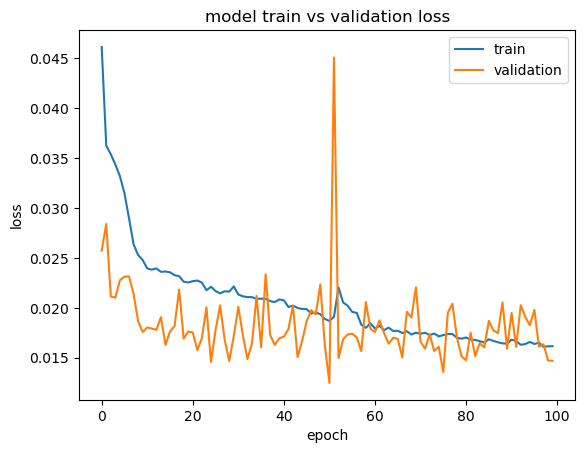

In [52]:
# Show MAE
mae_price = round(np.mean(history.history['val_mae_price'][-10:]), 4)
mean_price = round(cross_points_scaled.mean(axis=0)[0], 4)
mae_quantity = round(np.mean(history.history['val_mae_quantity'][-10:]), 4)
mean_quantity = round(cross_points_scaled.mean(axis=0)[1], 4)
print(f"   MAE Price: {mae_price} (Mean: {mean_price})")
print(f"MAE Quantity: {mae_quantity} (Mean: {mean_quantity})")

# Plot history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# Model development

In [ ]:
# Load test data
selected_days_test = sorted(list(data_curves_test.keys()))

# Extract curves
supply_curves_raw = []
demand_curves_raw = []
for day in selected_days_test:
    day_supply_curves = [interval["supply_curve"] for interval in data_curves_test[day].values()]
    supply_curves_raw = supply_curves_raw + day_supply_curves
    day_demand_curves = [interval["demand_curve"] for interval in data_curves_test[day].values()]
    demand_curves_raw = demand_curves_raw + day_demand_curves

# Process supply curves
supply_curves = pad_sequences(supply_curves_raw, padding='pre', dtype='float32', maxlen=n_in_supply)

# Process demand curves
demand_curves = pad_sequences(demand_curves_raw, padding='pre', dtype='float32', maxlen=n_in_demand)

# Get intersection points
cross_points_test = []
for i in range(len(demand_curves_raw)):
    x_point = find_intersection(supply_curves_raw[i], demand_curves_raw[i])
    cross_points_test.append(x_point)
cross_points_test = np.array(cross_points_test)

# Scale data
scaler_supply = MinMaxScaler()
scaler_demand = MinMaxScaler()
scaler_cross = MinMaxScaler()
supply_curves_scaled_test = scaler_supply.fit_transform(supply_curves.reshape(-1, 2)).reshape(supply_curves.shape)
demand_curves_scaled_test = scaler_demand.fit_transform(demand_curves.reshape(-1, 2)).reshape(demand_curves.shape)

In [65]:
# Generate embeddings
supply_curves_train_emb = encoder_supply.predict(supply_curves_scaled)
supply_curves_test_emb = encoder_supply.predict(supply_curves_scaled_test)
demand_curves_train_emb = encoder_demand.predict(demand_curves_scaled)
demand_curves_test_emb = encoder_demand.predict(demand_curves_scaled_test)

47/47 [==============================] - 1s 15ms/step
